In [1]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import ListedColormap, to_hex, to_rgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from anytree import AnyNode, RenderTree
from collections import Counter

import ujson
import os
import seaborn as sns

np.random.seed(0)

In [2]:
#!pip install bk_clustering
import bk_clustering
from bk_clustering import BurjKhalifaClustering

## Introduction

In [3]:
num_samples = 500
desired_mean = 50.0
desired_std_dev = 10.0

samples_0 = np.random.normal(loc=0.0, scale=desired_std_dev, size=[num_samples, 2])
samples_100 = np.random.normal(
    loc=100.0, scale=desired_std_dev * 3, size=[num_samples, 2]
)
samples_200 = np.random.normal(
    loc=200.0, scale=desired_std_dev / 3, size=[num_samples, 2]
)

Text(-12.5, 40, 'ClusterYellow')

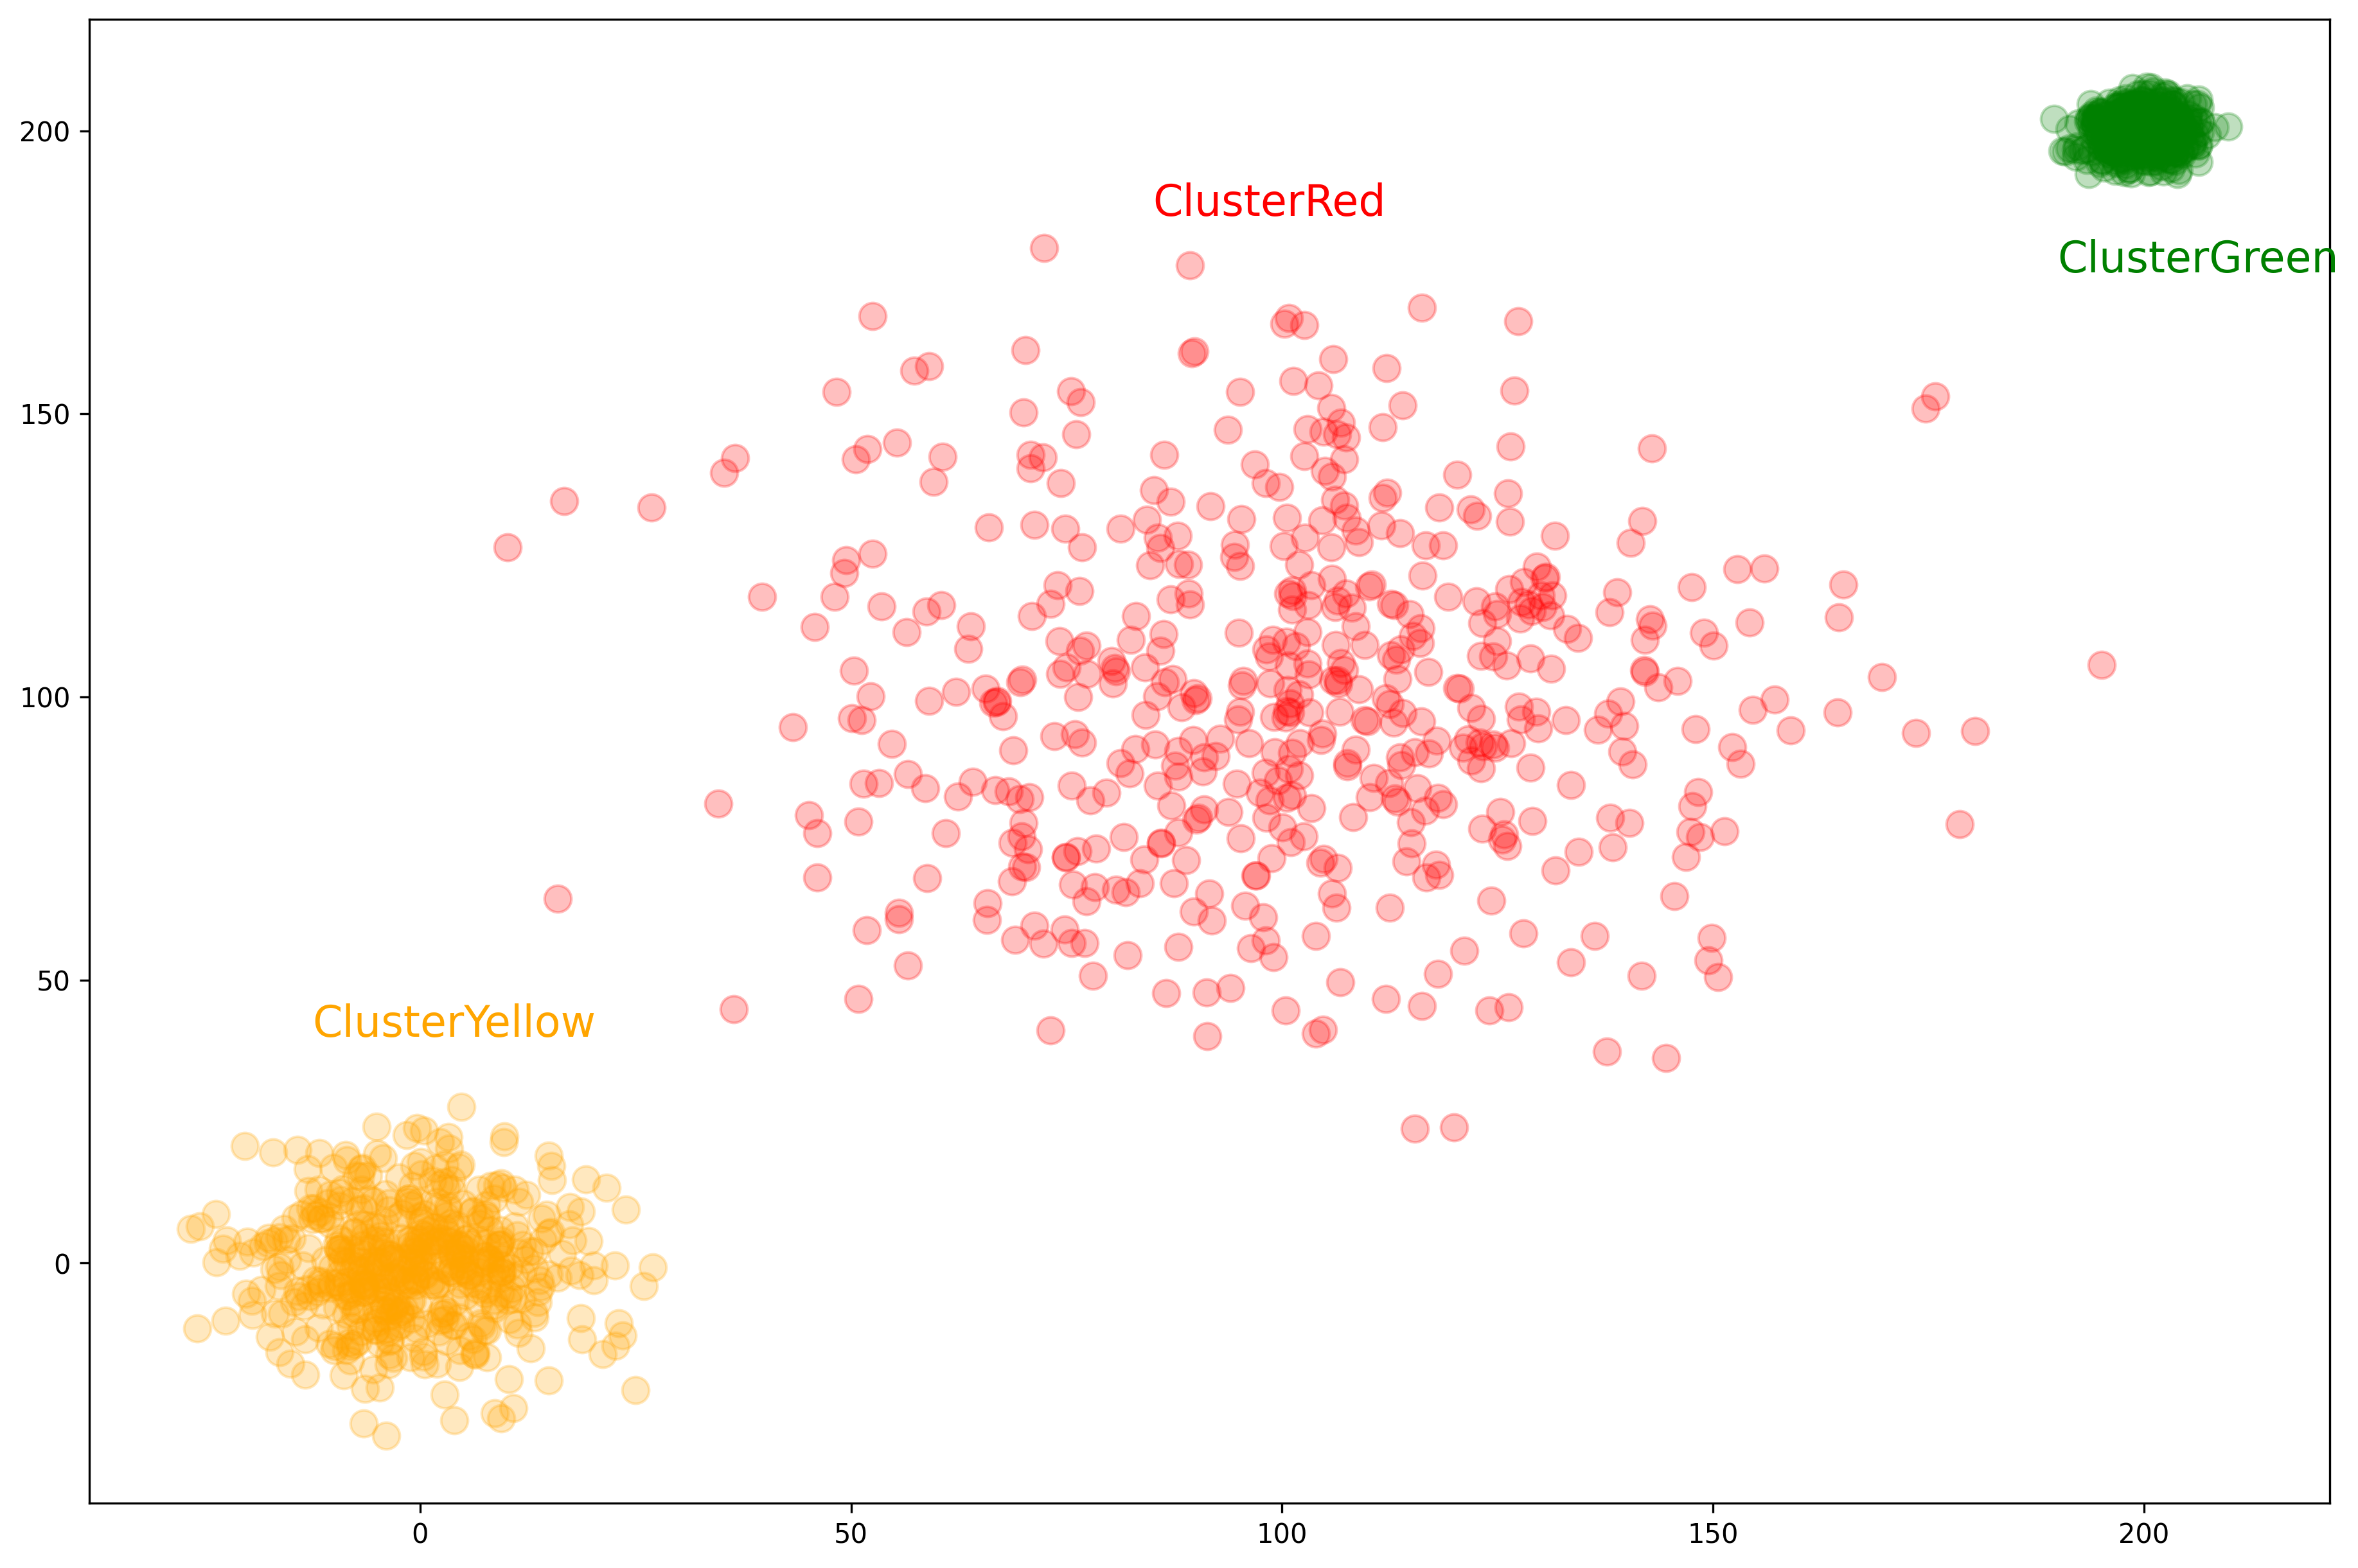

In [4]:
# Figure 1a

plt.figure(figsize=(15, 10), dpi=300)
plt.scatter(samples_0[:, 0], samples_0[:, 1], alpha=0.25, c="orange", s=100)
plt.scatter(samples_100[:, 0], samples_100[:, 1], alpha=0.25, c="red", s=100)
plt.scatter(samples_200[:, 0], samples_200[:, 1], alpha=0.25, c="green", s=100)
plt.annotate("ClusterRed", (85, 185), fontsize=16, color="Red")
plt.annotate("ClusterGreen", (190, 175), fontsize=16, color="Green")
plt.annotate("ClusterYellow", (-12.5, 40), fontsize=16, color="Orange")

In [5]:
X = np.vstack((samples_0, samples_100, samples_200))
dtf = linkage(X, "ward")

Text(500, 300, 'ClusterYellow')

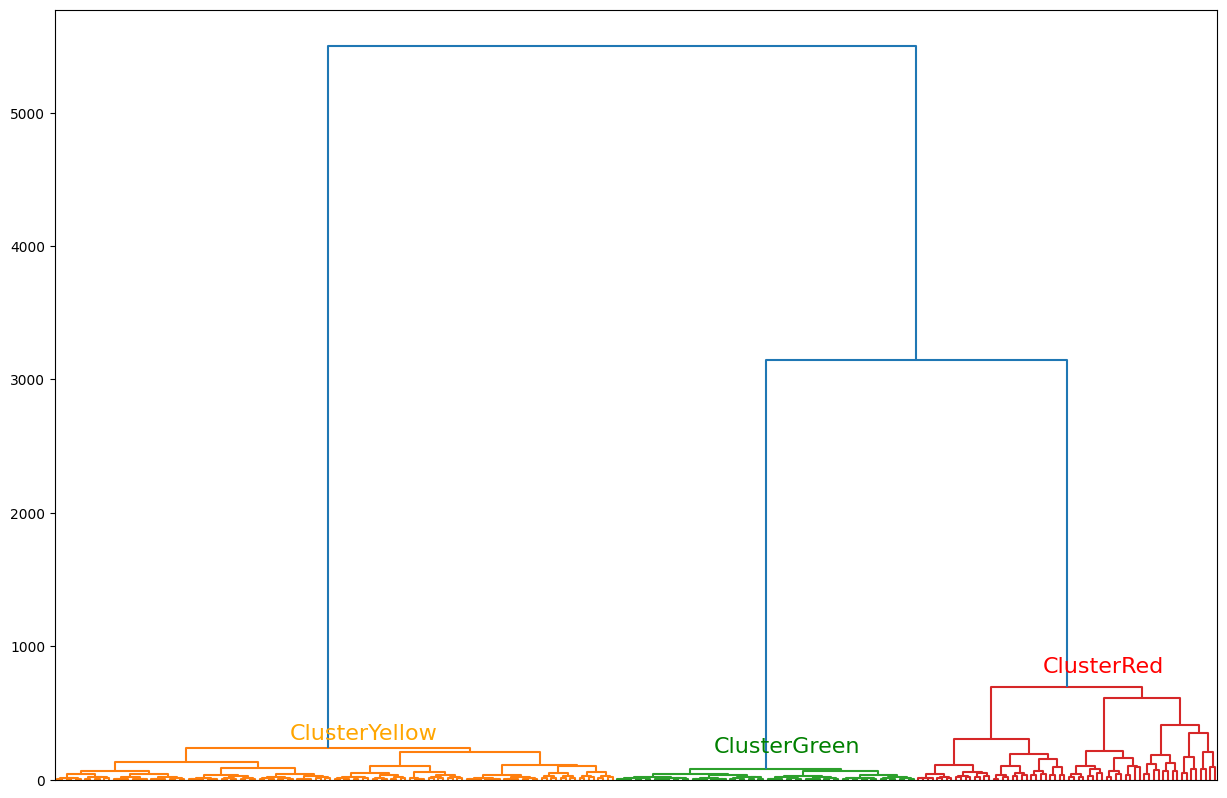

In [6]:
# Figure 1b

plt.figure(figsize=(15, 10))
_ = dendrogram(dtf, color_threshold=2000, no_labels=True, truncate_mode="level", p=7)
plt.annotate("ClusterRed", (2100, 800), fontsize=16, color="Red")
plt.annotate("ClusterGreen", (1400, 200), fontsize=16, color="Green")
plt.annotate("ClusterYellow", (500, 300), fontsize=16, color="Orange")

## Method

In [7]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(X)

In [8]:
dtf = bk_model.dtf_

In [9]:
labels = [2991, 2988, 2966, 2997, 2996, 2992, 2995, 2998]
cols = ["height", "count", "height_to_next", "solidity"]

In [10]:
# Table 3
bk_model.cluster_df_.loc[labels, cols].sort_index()

height   count  height_to_next     solidity
2966    15.104412   500.0      557.153166  1221.059804
2988    37.924509   306.0        6.460033     1.374410
2991    44.384542   500.0      955.615458   242.543524
2992    56.156034   124.0       70.387622     2.767739
2995   111.567285   376.0       14.976371     0.452398
2996   126.543656   500.0      445.713922    13.916994
2997   572.257578  1000.0      427.742422     1.306169
2998  1000.000000  1500.0    -1000.000000    -1.500000

In [11]:
x = [160.0, 240, 400, 480.0, 560.0, 519, 600, 320.0]
y = list(bk_model.cluster_df_.loc[labels]["height"])
heights = list(
    bk_model.cluster_df_.loc[x]["height"] if x != "root" else -1
    for x in bk_model.cluster_df_.loc[labels]["parent"]
)

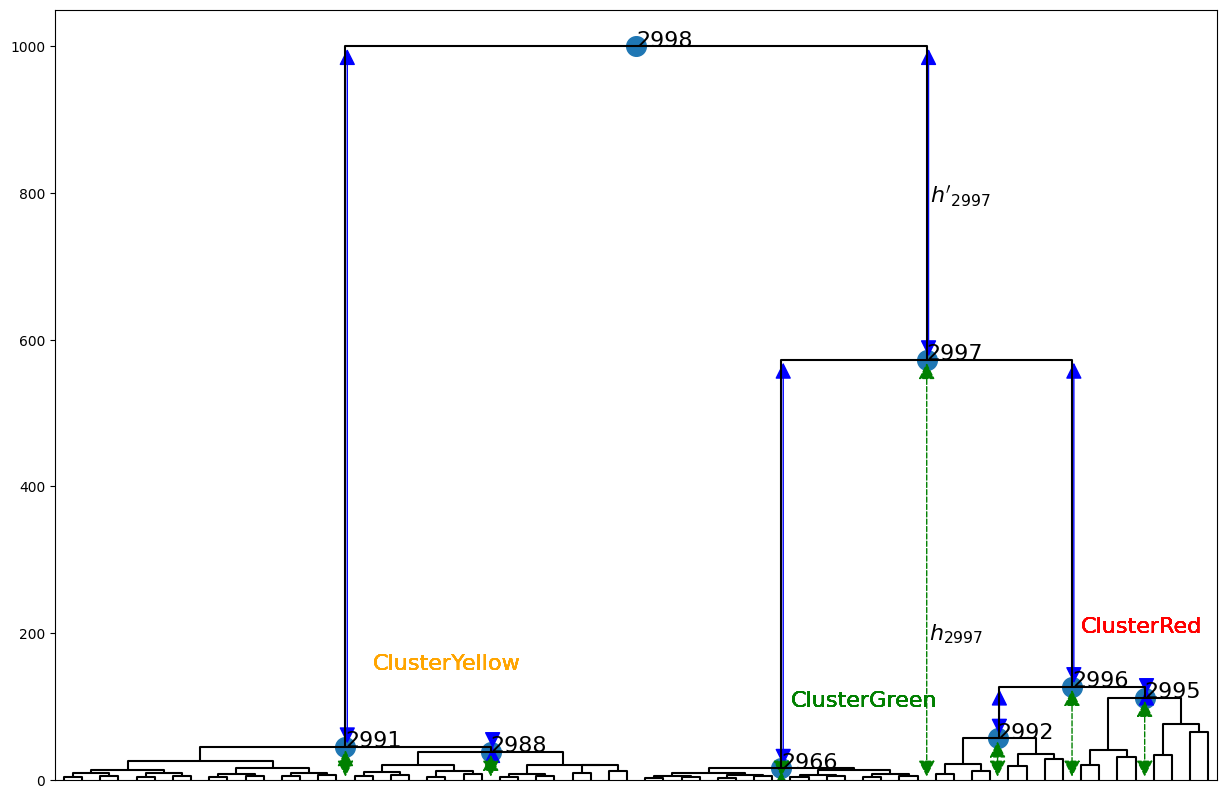

In [12]:
# Figure 2

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    truncate_mode="level",
    p=5,
    no_labels=True,
)
ax.scatter(x=x, y=y, s=200)
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), fontsize=16)
for i, (_x, _y, h, label) in enumerate(zip(x, y, heights, labels)):
    if i != len(heights) - 1:
        ax.add_patch(
            patches.FancyArrowPatch(
                (_x + 1, _y + 1),
                (_x + 1, h),
                arrowstyle="<|-|>",
                mutation_scale=25,
                color="blue",
            )
        )
        ax.add_patch(
            patches.FancyArrowPatch(
                (_x, _y - 0.5),
                (_x, 0),
                arrowstyle="<|-|>",
                mutation_scale=25,
                linestyle="--",
                color="green",
            )
        )
        ax.annotate("ClusterRed", (565, 200), fontsize=16, color="Red")
        ax.annotate("ClusterGreen", (405, 100), fontsize=16, color="Green")
        ax.annotate("ClusterYellow", (175, 150), fontsize=16, color="Orange")
        if label == 2997:
            ax.annotate(r"$h'_{%s}$" % (label), (_x + 2, (h + _y) / 2), fontsize=16)
            ax.annotate(r"$h_{%s}$" % (label), (_x + 1, _y / 3), fontsize=16)

## Results

In [13]:
skip_datasets = [
    # missing values
    "water-treatment",
    "audiology",
    "autos",
    "credit.a",
    "credit.g",
    "cylinder.bands",
    "eucalyptus",
    "hepatitis",
    "hypothyroid",
    "mushroom",
    "primary.tumor",
    "sick",
    "soybean",
    "vote",
    "Autism_Data",
    "WISDM_ar_v1.1_transformed",
    "Lymphoma",
    # multiple duplicated column names
    "Colon",
    # gmm throws error
    "jm1",
    "KDDTest+",
    # other reasons
    "Rice_MSC_Dataset",  # to run separately
    "click_data",  # why does it takes so long for kmeans?
]
folders = ["real", "artificial"]
dataset_names = []
for folder in folders:
    dataset_names += [
        (folder, x[:-5])
        for x in os.listdir(f"./../data/{folder}")
        if x[:-5] not in skip_datasets
    ]
#dataset_shapes = {dataset_name: bk_clustering.utilities.load_save.read_arff(dataset_name[0], dataset_name[1]).shape[1] for dataset_name in dataset_names}
with open("./../data/dataset_shapes.json") as data_file:
    dataset_shapes = {eval(k): v for (k, v) in ujson.load(data_file).items()}

In [14]:
class_A_methods = [
    "bk_clustering",
    "affinity",
    "dbscan",
    "density_peak",
    "mean_shift",
    "optics",
]

class_R_methods = [
    "agglomerative",
    "birch",
    "gmm",
    "kmeans",
    "mb_kmeans",
]

sorted_methods = class_A_methods + class_R_methods

metrics_list = [
    "mutual_similarity_0",
    "mutual_similarity_1",
    "mutual_similarity_2",
    "rand_index_0",
    "rand_index_1",
    "fm_score",
    "v_measure_0",
    "v_measure_1",
    "v_measure_2",
]

method_dict = {
    "bk_clustering": "A0: Proposed method",
    "affinity": "A1: Affinity Propogation",
    "dbscan": "A2: DBSCAN",
    "density_peak": "A3: Fast Search",
    "mean_shift": "A4: Mean Shift",
    "optics": "A5: OPTICS",
    "agglomerative": "R1: Agglomerative",
    "birch": "R2: BIRCH",
    "gmm": "R3: Gaussian Mixture Models",
    "kmeans": "R4: k-Means",
    "mb_kmeans": "R5: Mini-batch k-Means",
}

title_dict = {
    "mutual_similarity_0": "Mutual Information (MI)",
    "mutual_similarity_1": "Normalized Mutual Information (NMI)",
    "mutual_similarity_2": "Adjusted Mutual Information (AMI)",
    "rand_index_0": "Rand Index (RI)",
    "rand_index_1": "Adjusted Rand Index (ARI)",
    "v_measure_0": "V-measure: Homogeneity",
    "v_measure_1": "V-measure: Completeness",
    "v_measure_2": "V-measure",
    "fm_score": "Fowlkes-Mallows Index (FMI)",
}

In [15]:
with open("./../results/bk_clustering_results.json") as data_file:
    bk_clustering_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/k_means_results.json") as data_file:
    k_means_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/mini_batch_kmeans_results.json") as data_file:
    mini_batch_kmeans_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/affinity_results.json") as data_file:
    affinity_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/agglomerative_results.json") as data_file:
    agglomerative_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/birch_results.json") as data_file:
    birch_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/dbscan_results.json") as data_file:
    dbscan_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/mean_shift_results.json") as data_file:
    mean_shift_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/optics_results.json") as data_file:
    optics_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/gaussian_mixture_results.json") as data_file:
    gaussian_mixture_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

with open("./../results/density_peak_results.json") as data_file:
    density_peak_results = {eval(k): v for (k, v) in ujson.load(data_file).items()}

In [16]:
all_methods_df = pd.DataFrame()

for dataset_name in dataset_names:
    method_df = pd.DataFrame()
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(bk_clustering_results[dataset_name], index=["bk_clustering"]),
        ]
    )
    method_df = pd.concat(
        [method_df, pd.DataFrame(k_means_results[dataset_name], index=["kmeans"])]
    )
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(mini_batch_kmeans_results[dataset_name], index=["mb_kmeans"]),
        ]
    )
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(agglomerative_results[dataset_name], index=["agglomerative"]),
        ]
    )
    method_df = pd.concat(
        [method_df, pd.DataFrame(affinity_results[dataset_name], index=["affinity"])]
    )
    method_df = pd.concat(
        [method_df, pd.DataFrame(birch_results[dataset_name], index=["birch"])]
    )
    method_df = pd.concat(
        [method_df, pd.DataFrame(dbscan_results[dataset_name], index=["dbscan"])]
    )
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(mean_shift_results[dataset_name], index=["mean_shift"]),
        ]
    )
    method_df = pd.concat(
        [method_df, pd.DataFrame(optics_results[dataset_name], index=["optics"])]
    )
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(gaussian_mixture_results[dataset_name], index=["gmm"]),
        ]
    )
    method_df = pd.concat(
        [
            method_df,
            pd.DataFrame(density_peak_results[dataset_name], index=["density_peak"]),
        ]
    )
    method_df["log_performance"] = np.log(method_df["performance_s"])
    method_df["dataset"] = dataset_name[1]
    method_df["n_cols"] = dataset_shapes[dataset_name]
    all_methods_df = pd.concat([all_methods_df, method_df])
all_methods_df.reset_index(inplace=True)

all_methods_df["index"] = all_methods_df["index"].astype("category")
all_methods_df["index"] = all_methods_df["index"].cat.set_categories(sorted_methods, ordered=True)
all_methods_df.replace({"index": method_dict}, inplace=True)
all_methods_df.rename(columns = title_dict, inplace=True)
all_methods_df = all_methods_df.sort_values("index")

In [17]:
# all methods have same number of dataset
all_methods_df["index"].value_counts()

A0: Proposed method            191
A1: Affinity Propogation       191
A2: DBSCAN                     191
A3: Fast Search                191
A4: Mean Shift                 191
A5: OPTICS                     191
R1: Agglomerative              191
R2: BIRCH                      191
R3: Gaussian Mixture Models    191
R4: k-Means                    191
R5: Mini-batch k-Means         191
Name: index, dtype: int64

In [18]:
# all dataset used same number of times
all_methods_df["dataset"].value_counts().sort_values()

contact-lenses    11
D31               11
zelnik2           11
aggregation       11
wine              11
                  ..
sizes5            11
spiral            11
Leukemia_4c       11
sizes4            11
aml28             11
Name: dataset, Length: 191, dtype: int64

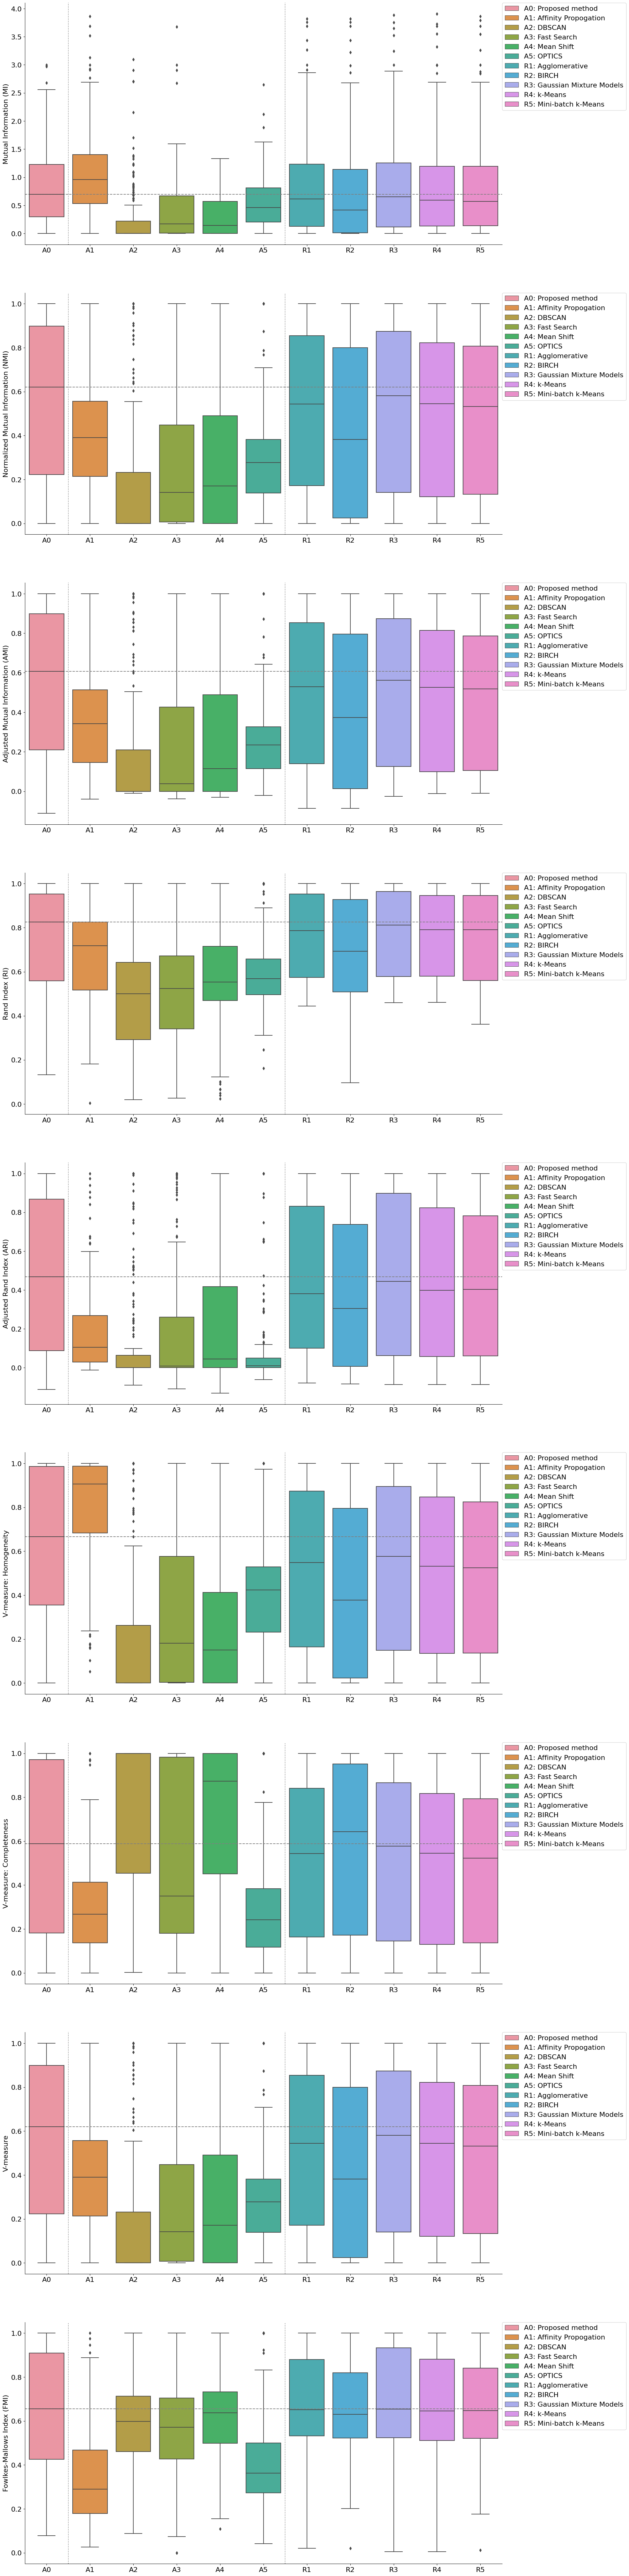

In [19]:
# Figure 3-6

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_list), 1, figsize=(20, len(metrics_list) * 12))

for idx, col in enumerate(title_dict.values()):
    sns.boxplot(
        data=all_methods_df,
        x="index",
        y=col,
        hue="index",
        ax=ax[idx],
        dodge=False,
    )
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[all_methods_df["index"] == "A0: Proposed method"].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

In [20]:
# Table 4

agg_df = all_methods_df.groupby(["index"]).median()[list(title_dict.values())]
#agg_df.to_csv("./../results/median_aggregated_results.csv")
agg_df

/tmp/ipykernel_97047/1842729949.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = all_methods_df.groupby(["index"]).median()[list(title_dict.values())]


Mutual Information (MI)  \
index                                                  
A0: Proposed method                         0.698382   
A1: Affinity Propogation                    0.961157   
A2: DBSCAN                                  0.000000   
A3: Fast Search                             0.171079   
A4: Mean Shift                              0.141655   
A5: OPTICS                                  0.459139   
R1: Agglomerative                           0.615712   
R2: BIRCH                                   0.417515   
R3: Gaussian Mixture Models                 0.653498   
R4: k-Means                                 0.594081   
R5: Mini-batch k-Means                      0.571682   

                             Normalized Mutual Information (NMI)  \
index                                                              
A0: Proposed method                                     0.620110   
A1: Affinity Propogation                                0.390740   
A2: DBSCAN                                              0.000000   
A3: Fast Search                                         0.141304   
A4: Mean Shift                                          0.170864   
A5: OPTICS                                              0.277485   
R1: Agglomerative                                       0.543820   
R2: BIRCH                                               0.381958   
R3: Gaussian Mixture Models                             0.580878   
R4: k-Means                                             0.544143   
R5: Mini-batch k-Means                                  0.531806   

                             Adjusted Mutual Information (AMI)  \
index                                                            
A0: Proposed method                                   0.607284   
A1: Affinity Propogation                              0.341917   
A2: DBSCAN                                            0.000000   
A3: Fast Search                                       0.037755   
A4: Mean Shift                                        0.113888   
A5: OPTICS                                            0.234517   
R1: Agglomerative                                     0.528981   
R2: BIRCH                                             0.372547   
R3: Gaussian Mixture Models                           0.561643   
R4: k-Means                                           0.525728   
R5: Mini-batch k-Means                                0.518270   

                             Rand Index (RI)  Adjusted Rand Index (ARI)  \
index                                                                     
A0: Proposed method                 0.825129                   0.468613   
A1: Affinity Propogation            0.717878                   0.103862   
A2: DBSCAN                          0.499444                   0.000000   
A3: Fast Search                     0.523911                   0.007219   
A4: Mean Shift                      0.552878                   0.044783   
A5: OPTICS                          0.568670                   0.009947   
R1: Agglomerative                   0.785986                   0.381372   
R2: BIRCH                           0.692331                   0.304996   
R3: Gaussian Mixture Models         0.812021                   0.444113   
R4: k-Means                         0.790785                   0.398557   
R5: Mini-batch k-Means              0.790423                   0.402213   

                             V-measure: Homogeneity  V-measure: Completeness  \
index                                                                          
A0: Proposed method                        0.666326                 0.588891   
A1: Affinity Propogation                   0.906251                 0.268083   
A2: DBSCAN                                 0.000000                 1.000000   
A3: Fast Search                            0.181798                 0.350671   
A4: Mean Shift                             0.151126                 0.873122   
A5: OPTICS          

## Discussion

### Outlier detection

In [21]:
outliers = [[0, 50], [50, 50], [50, 0]]
samples_x = np.vstack((samples_0, outliers))

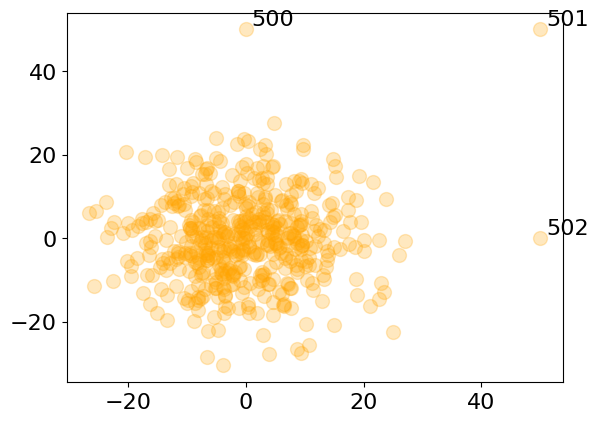

In [22]:
plt.scatter(samples_x[:, 0], samples_x[:, 1], alpha=0.25, c="orange", s=100)
for idx, out in enumerate(outliers):
    plt.annotate(len(samples_0) + idx, (out[0] + 1, out[1] + 1))

In [23]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(samples_x)
dtf = bk_model.dtf_

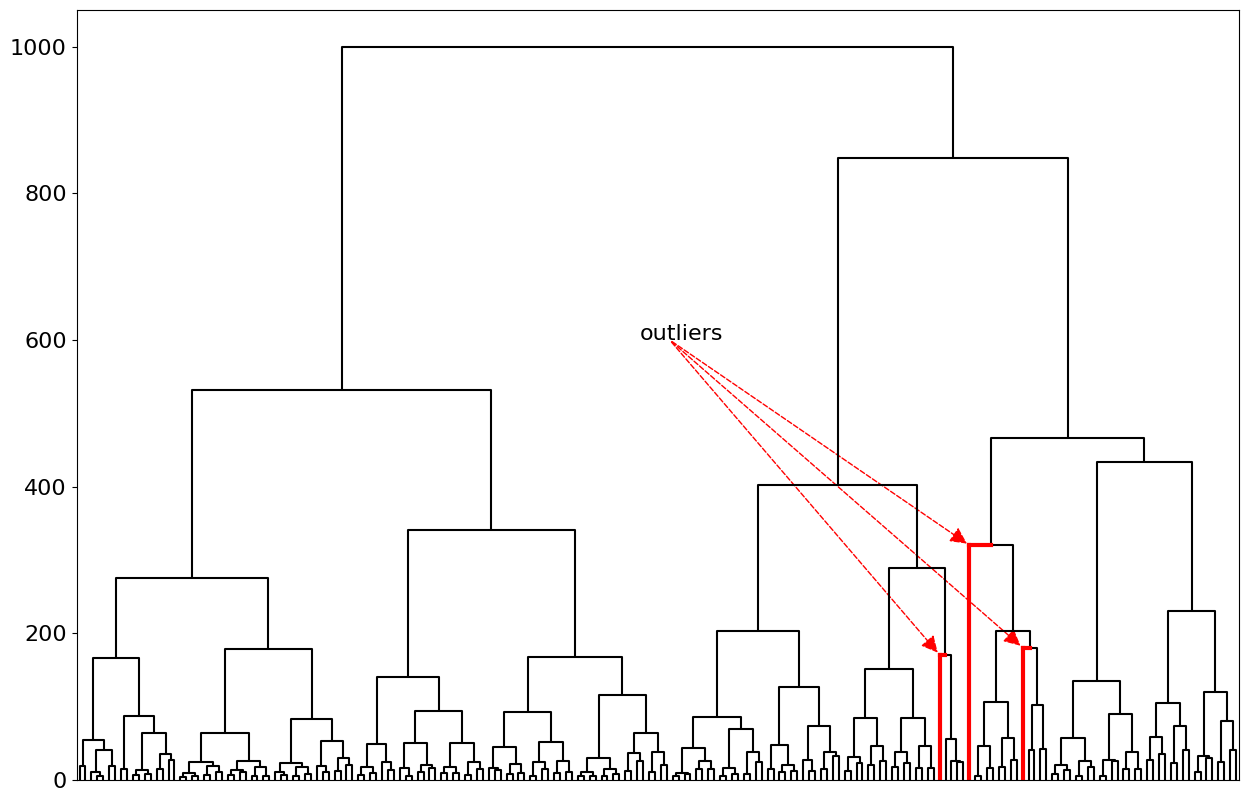

In [24]:
# Figure 7

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    no_labels=True,
    truncate_mode="level",
    p=7,
)

for idx in [-35, -37, -50]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][0]], [
        _["dcoord"][idx][0],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

    ax.add_patch(
        patches.FancyArrowPatch(
            (1000, 600),
            (x2[0], y2[0]),
            arrowstyle="-|>",
            mutation_scale=25,
            linestyle="--",
            color="red",
        )
    )

ax.annotate("outliers", (950, 600), fontsize=16)
plt.show()

In [25]:
# Table 5

bk_model.cluster_df_[bk_model.cluster_df_["level"] < 3].sort_values(
    "solidity", ascending=False
)[["height", "count", "height_to_next", "solidity"]].head(5)

height  count  height_to_next    solidity
501     1.0    1.0      319.238431  193.575654
500     1.0    1.0      179.605192  108.906664
502     1.0    1.0      169.783028  102.950828
367     1.0    1.0       54.422418   32.999959
471     1.0    1.0       32.618185   19.778592

In [26]:
outliers += [[51, -1], [51, 1]]
samples_x = np.vstack((samples_0, outliers))

Text(45.0, 2.0, '504')

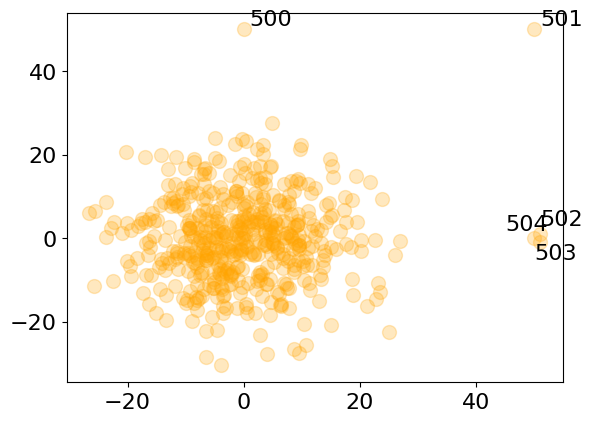

In [27]:
# Figure 9a

plt.scatter(samples_x[:, 0], samples_x[:, 1], alpha=0.25, c="orange", s=100)
for out in [500, 501]:
    # plt.scatter(samples_x[out,0],samples_x[out,1], c="black")
    plt.annotate(out, (samples_x[out, 0] + 1, samples_x[out, 1] + 1))
plt.annotate(502, (samples_x[502, 0] + 1, samples_x[502, 1] + 3))
plt.annotate(503, (samples_x[503, 0] - 1, samples_x[503, 1] - 4))
plt.annotate(504, (samples_x[504, 0] - 6, samples_x[504, 1] + 1))

In [28]:
bk_model = BurjKhalifaClustering(linkage="ward")
bk_model.fit(samples_x)
dtf = bk_model.dtf_

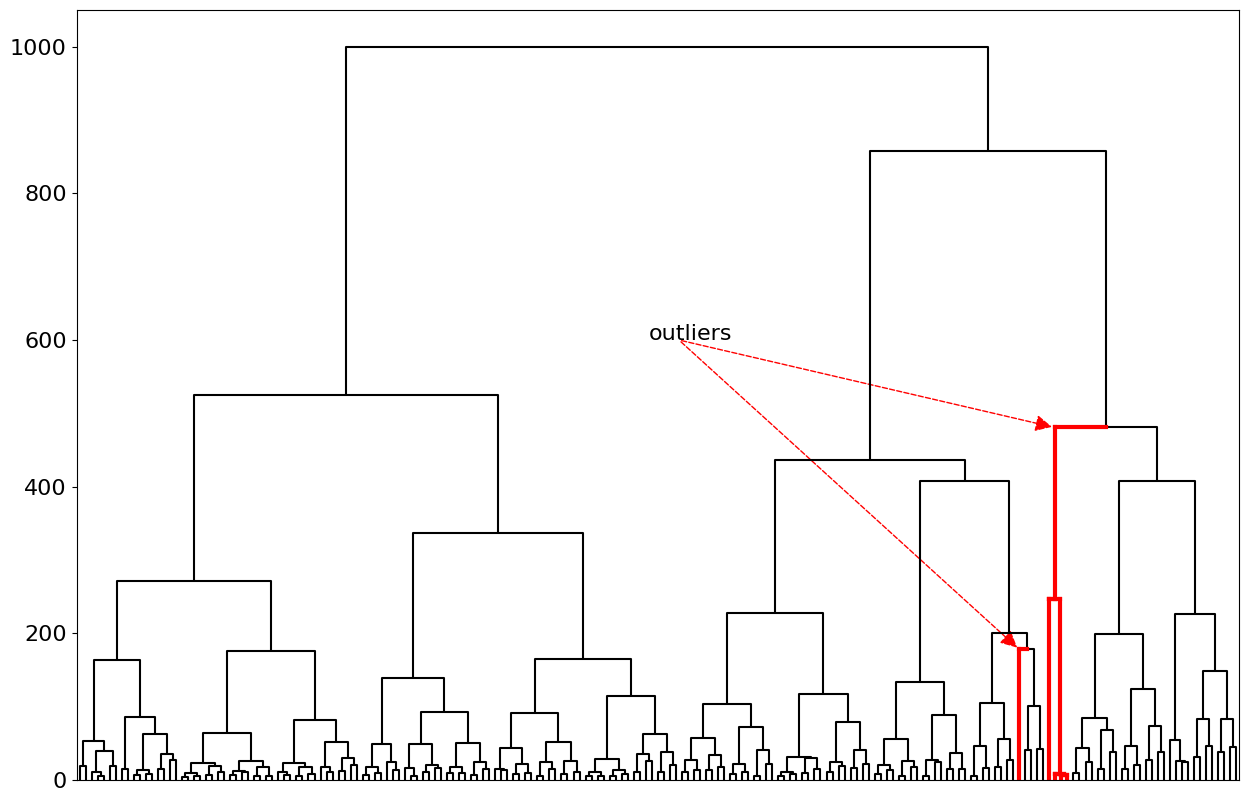

In [29]:
# Figure 9b

fig, ax = plt.subplots(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: "#000000",
    no_labels=True,
    truncate_mode="level",
    p=7,
)

# -3, -30, -31, -32, -37

for idx in [-3, -31, -32, -33, -37]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][0]], [
        _["dcoord"][idx][0],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

for idx in [-31, -32, -33]:
    x1, y1 = [_["icoord"][idx][0], _["icoord"][idx][2]], [
        _["dcoord"][idx][2],
        _["dcoord"][idx][2],
    ]
    x2, y2 = [_["icoord"][idx][2], _["icoord"][idx][2]], [
        _["dcoord"][idx][1],
        _["dcoord"][idx][3],
    ]
    ax.plot(x1, y1, x2, y2, color="red", linewidth=3)

for idx in [-3, -37]:
    x2, y2 = [
        _["icoord"][idx][0],
        _["icoord"][idx][2] - (_["icoord"][idx][2] - _["icoord"][idx][0]) / 2,
    ], [_["dcoord"][idx][1], _["dcoord"][idx][1]]
    ax.add_patch(
        patches.FancyArrowPatch(
            (1000, 600),
            (x2[0], y2[0]),
            arrowstyle="-|>",
            mutation_scale=25,
            linestyle="--",
            color="red",
        )
    )

ax.annotate("outliers", (950, 600), fontsize=16)
plt.show()

### Tree cuts vs solidity

In [30]:
dataset_name = ("artificial", "aggregation")
df = bk_clustering.utilities.load_save.read_arff(dataset_name[0], dataset_name[1])
X, true_labels = df.loc[:, df.columns != "class"], df["class"]

In [31]:
bk_model = BurjKhalifaClustering(n_clusters=true_labels.nunique(), linkage="ward")
bk_model.fit(X)
dtf = bk_model.dtf_

In [32]:
color_map = mpl.colormaps["tab10"]
color_map_hex = [to_hex(col) for col in color_map.colors]
map_true = {1: 1, 2: 2, 3: 3, 4: 9, 5: 5, 6: 6, 7: 7}
map_bk = {1549: 1, 1568: 2, 1562: 3, 1569: 9, 1515: 5, 1565: 6, 1531: 7}
map_ag = {5: 1, 0: 2, 3: 3, 2: 9, 6: 8, 1: 5, 4: 6, 7: 7}

In [33]:
def set_color(k):
    if k > 1569:
        return "#000000"
    idx = true_labels[bk_model.node_tree_.tree_structure[k].leaves[0].id]
    return color_map_hex[map_true[idx]]

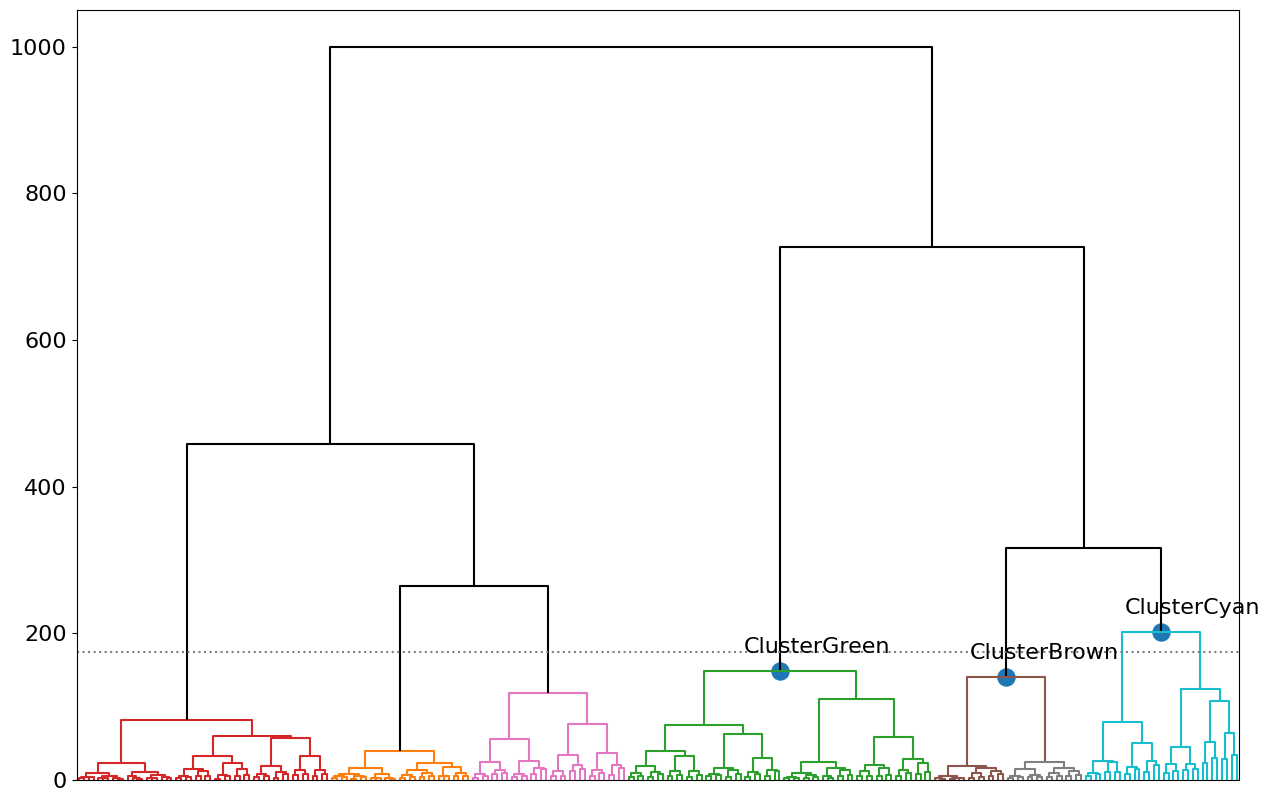

In [34]:
# Figure 10

plt.figure(figsize=(15, 10))
_ = dendrogram(
    dtf.iloc[:, :4],
    link_color_func=lambda k: set_color(k),
    no_labels=True,
    truncate_mode="level",
    p=7,
)
plt.axhline(y=175, linestyle="dotted", color="gray")

joint_list = [-4, -35, -65]
x, y = [], []
cluster_labels = ["Cyan", "Brown", "Green"]
for idx, j in enumerate(joint_list):
    x.append(_["icoord"][j][1] + (_["icoord"][j][2] - _["icoord"][j][1]) / 2)
    y.append(_["dcoord"][j][1])
    plt.annotate(
        f"Cluster{cluster_labels[idx]}",
        (
            _["icoord"][j][1] + (_["icoord"][j][2] - _["icoord"][j][1]) / 2 - 75,
            25 + _["dcoord"][j][1],
        ),
        fontsize=16,
    )

plt.scatter(x=x, y=y, s=150)

In [35]:
# Table 6
labels = [1567, 1568, 1569]
cols = ["height", "count", "height_to_next", "children", "solidity"]
bk_model.cluster_df_.loc[labels, cols].sort_values(["height"], ascending=False)

height  count  height_to_next      children  solidity
1569  201.904778  273.0      114.655182  [1561, 1566]  0.767827
1568  148.470609  170.0      578.117447  [1559, 1564]  4.458451
1567  139.864502   68.0      176.695459  [1515, 1531]  0.614213

In [36]:
labels = [1561, 1566, 1559, 1564, 1515, 1531]
cols = ["height", "count", "height_to_next", "solidity"]
bk_model.cluster_df_.loc[labels, cols].sort_values(["height"], ascending=False)

height  count  height_to_next   solidity
1566  124.578800  179.0       77.325978   0.891847
1564  109.952491   84.0       38.518118   0.267630
1561   79.655413   94.0      122.249365   1.811106
1559   75.081057   86.0       73.389552   1.119623
1531   24.273124   34.0      115.591378   6.670417
1515   18.703175   34.0      121.161327  11.776392

In [37]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=true_labels.nunique()).fit(X)

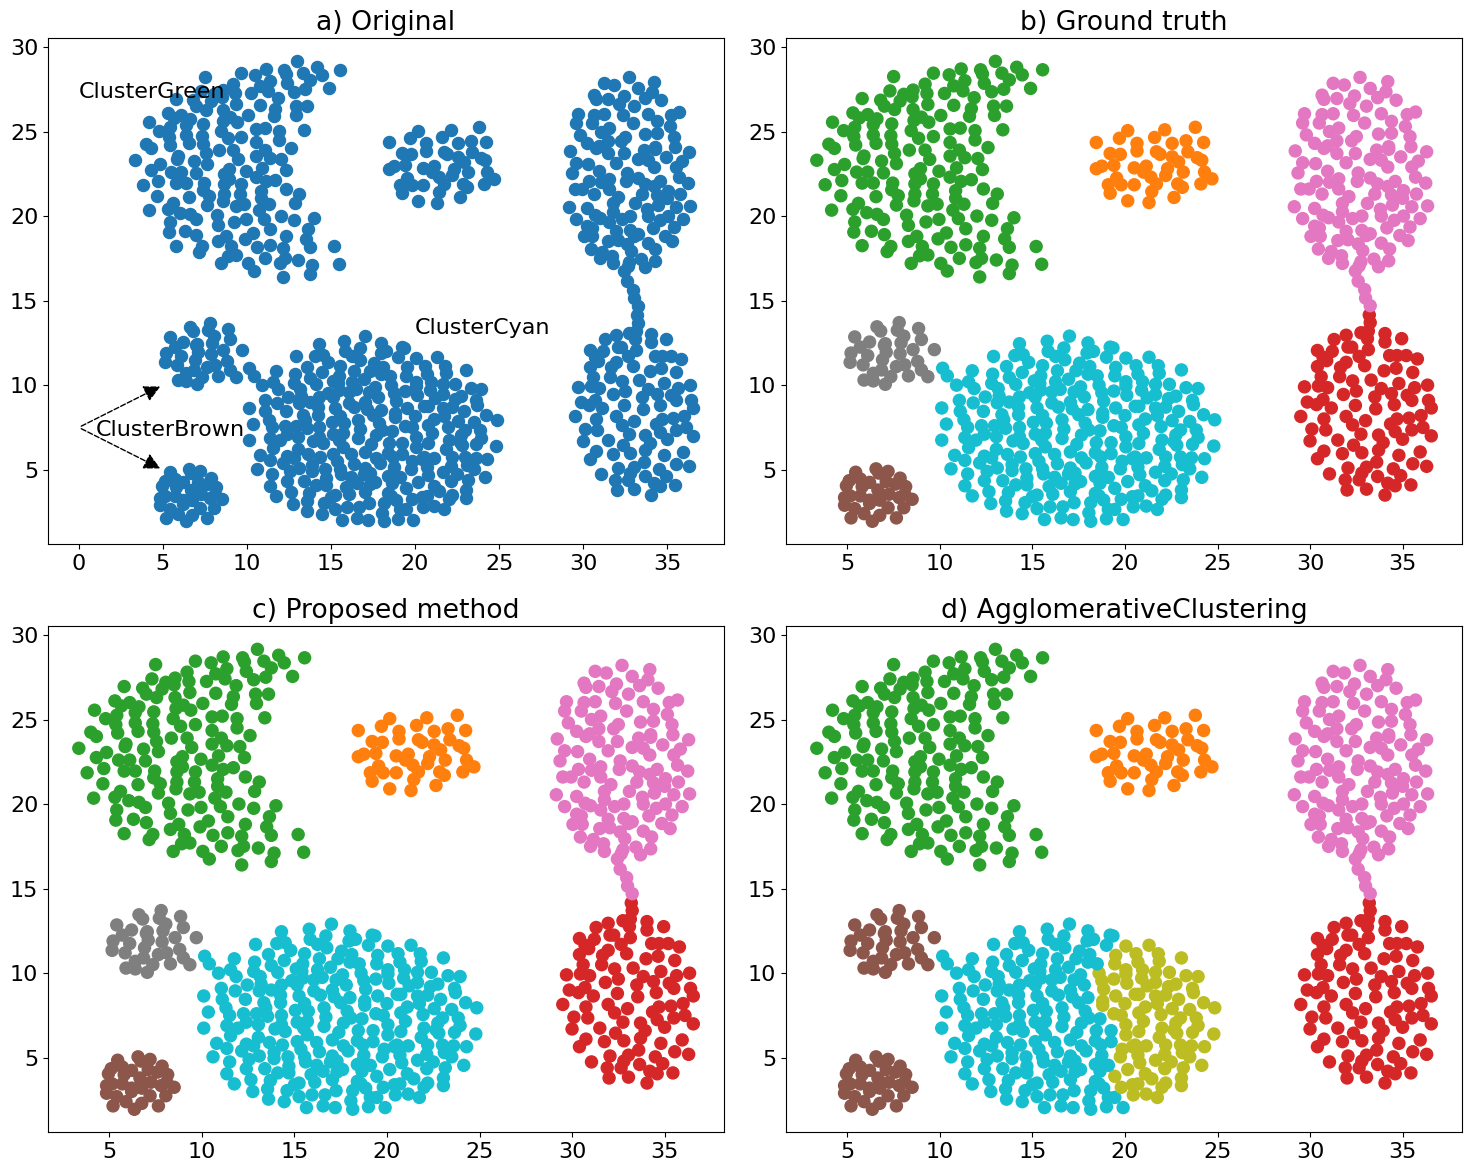

In [38]:
# Figure 11

_xarr, _yarr = X["x"], X["y"]

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
# define custom color map - need to handle 100% of fails
cmap = "tab10"
axs[0, 0].scatter(_xarr, _yarr, s=75)
axs[0, 0].set_title("a) Original")
axs[0, 1].scatter(
    _xarr, _yarr, c=[color_map.colors[map_true[x]] for x in true_labels], s=75
)
axs[0, 1].set_title("b) Ground truth")
axs[1, 0].scatter(
    _xarr, _yarr, c=[color_map.colors[map_bk[x]] for x in bk_model.labels_], s=75
)
axs[1, 0].set_title("c) Proposed method")
axs[1, 1].scatter(
    _xarr, _yarr, c=[color_map.colors[map_ag[x]] for x in model.labels_], s=75
)
axs[1, 1].set_title("d) AgglomerativeClustering")

axs[0, 0].add_patch(
    patches.FancyArrowPatch(
        (0, 7.5),
        (5, 10),
        arrowstyle="-|>",
        mutation_scale=25,
        linestyle="--",
        color="black",
    )
)
axs[0, 0].add_patch(
    patches.FancyArrowPatch(
        (0, 7.5),
        (5, 5),
        arrowstyle="-|>",
        mutation_scale=25,
        linestyle="--",
        color="black",
    )
)
axs[0, 0].annotate("ClusterBrown", (1, 7), fontsize=16)
axs[0, 0].annotate("ClusterCyan", (20, 13), fontsize=16)
axs[0, 0].annotate("ClusterGreen", (0, 27), fontsize=16)

fig.tight_layout()
plt.show()

### Additional plots

In [39]:
all_methods_df['n_cols_binary'] = all_methods_df['n_cols'].apply(lambda x: 1 if x > all_methods_df['n_cols'].median() else 0)
all_methods_df['n_rows_binary'] = all_methods_df['number_of_datapoints'].apply(lambda x: 1 if x > all_methods_df['number_of_datapoints'].median() else 0)
all_methods_df['n_clusters_binary'] = all_methods_df['clusters_true'].apply(lambda x: 1 if x > all_methods_df['clusters_true'].median() else 0)

In [40]:
pd.pivot_table(all_methods_df, values=list(title_dict.values()), index=["n_cols_binary","index"],
                       aggfunc=np.median)

Adjusted Mutual Information (AMI)  \
n_cols_binary index                                                            
0             A0: Proposed method                                   0.789404   
              A1: Affinity Propogation                              0.413856   
              A2: DBSCAN                                            0.000000   
              A3: Fast Search                                       0.133853   
              A4: Mean Shift                                        0.378891   
              A5: OPTICS                                            0.278920   
              R1: Agglomerative                                     0.703638   
              R2: BIRCH                                             0.603951   
              R3: Gaussian Mixture Models                           0.778897   
              R4: k-Means                                           0.713462   
              R5: Mini-batch k-Means                                0.700504   
1             A0: Proposed method                                   0.209456   
              A1: Affinity Propogation                              0.182101   
              A2: DBSCAN                                            0.000000   
              A3: Fast Search                                       0.014091   
              A4: Mean Shift                                        0.004248   
              A5: OPTICS                                            0.105270   
              R1: Agglomerative                                     0.214982   
              R2: BIRCH                                             0.214920   
              R3: Gaussian Mixture Models                           0.244031   
              R4: k-Means                                           0.255414   
              R5: Mini-batch k-Means                                0.233046   

                                           Adjusted Rand Index (ARI)  \
n_cols_binary index                                                    
0             A0: Proposed method                           0.687729   
              A1: Affinity Propogation                      0.146414   
              A2: DBSCAN                                    0.000000   
              A3: Fast Search                               0.031750   
              A4: Mean Shift                                0.210419   
              A5: OPTICS                                    0.014145   
              R1: Agglomerative                             0.638779   
              R2: BIRCH                                     0.437521   
              R3: Gaussian Mixture Models                   0.731125   
              R4: k-Means                                   0.642572   
              R5: Mini-batch k-Means                        0.588105   
1             A0: Proposed method                           0.137241   
              A1: Affinity Propogation                      0.051945   
              A2: DBSCAN                                    0.000000   
              A3: Fast Search                               0.001310   
              A4: Mean Shift                                0.002974   
              A5: OPTICS                                    0.003717   
              R1: Agglomerative                             0.162162   
              R2: BIRCH                                     0.156809   
              R3: Gaussian Mixture Models                   0.171011   
              R4: k-Means                                   0.164942   
              R5: Mini-batch k-Means                        0.158813   

                                           Fowlkes-Mallows Index (FMI)  \
n_cols_binary index                                                      
0             A0: Proposed method                             0.761519   
              A1: Affinity Propogation                        0.336067   
              A2: DBSCAN                                      0.586330   
              A3: Fast 

In [41]:
metrics_5_list = ['Normalized Mutual Information (NMI)', 'Adjusted Mutual Information (AMI)', 'Adjusted Rand Index (ARI)','V-measure', 'Fowlkes-Mallows Index (FMI)']

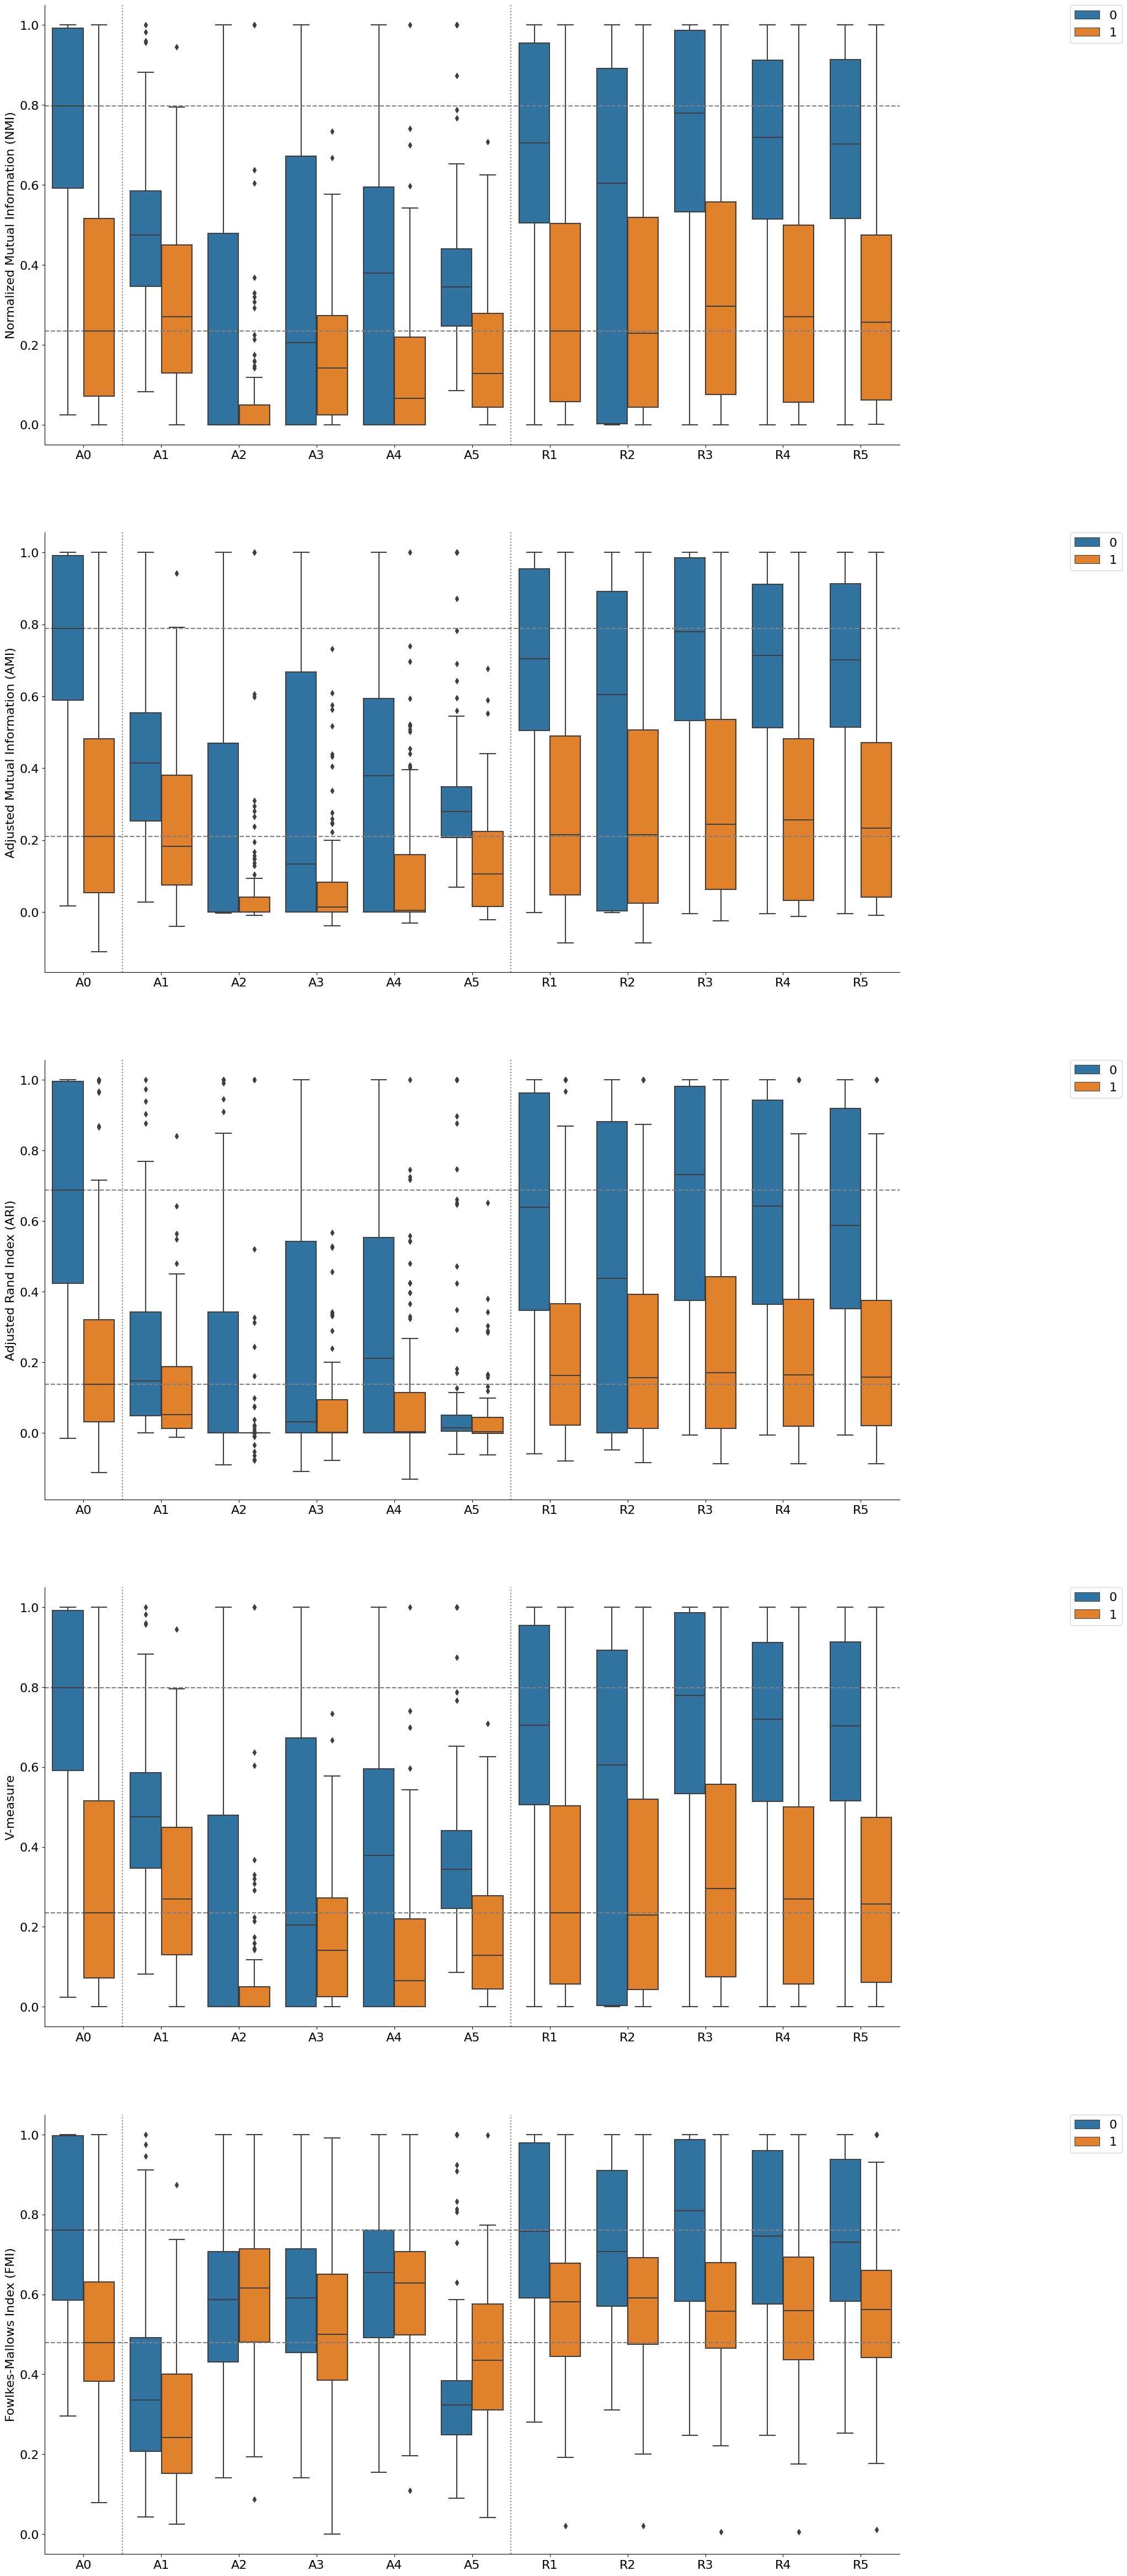

In [42]:
# Figure 3-6

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_cols_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(
        data=all_methods_df,
        x="index",
        y=col,
        hue=hue,
        ax=ax[idx],
        dodge=True
    )
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 0)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 1)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

In [43]:
pd.pivot_table(all_methods_df, values=list(title_dict.values()), index=["n_rows_binary","index"],
                       aggfunc=np.median)

Adjusted Mutual Information (AMI)  \
n_rows_binary index                                                            
0             A0: Proposed method                                   0.650060   
              A1: Affinity Propogation                              0.370320   
              A2: DBSCAN                                            0.000000   
              A3: Fast Search                                       0.083917   
              A4: Mean Shift                                        0.113888   
              A5: OPTICS                                            0.238451   
              R1: Agglomerative                                     0.514191   
              R2: BIRCH                                             0.218827   
              R3: Gaussian Mixture Models                           0.549978   
              R4: k-Means                                           0.512451   
              R5: Mini-batch k-Means                                0.495208   
1             A0: Proposed method                                   0.516136   
              A1: Affinity Propogation                              0.241355   
              A2: DBSCAN                                            0.000000   
              A3: Fast Search                                       0.002126   
              A4: Mean Shift                                        0.117781   
              A5: OPTICS                                            0.222333   
              R1: Agglomerative                                     0.571946   
              R2: BIRCH                                             0.552460   
              R3: Gaussian Mixture Models                           0.589907   
              R4: k-Means                                           0.573237   
              R5: Mini-batch k-Means                                0.562207   

                                           Adjusted Rand Index (ARI)  \
n_rows_binary index                                                    
0             A0: Proposed method                           0.557939   
              A1: Affinity Propogation                      0.164927   
              A2: DBSCAN                                    0.000000   
              A3: Fast Search                               0.078398   
              A4: Mean Shift                                0.060597   
              A5: OPTICS                                    0.017970   
              R1: Agglomerative                             0.376238   
              R2: BIRCH                                     0.159387   
              R3: Gaussian Mixture Models                   0.460514   
              R4: k-Means                                   0.402213   
              R5: Mini-batch k-Means                        0.394775   
1             A0: Proposed method                           0.279901   
              A1: Affinity Propogation                      0.033280   
              A2: DBSCAN                                    0.000000   
              A3: Fast Search                               0.000023   
              A4: Mean Shift                                0.041214   
              A5: OPTICS                                    0.004670   
              R1: Agglomerative                             0.416924   
              R2: BIRCH                                     0.397382   
              R3: Gaussian Mixture Models                   0.432849   
              R4: k-Means                                   0.383870   
              R5: Mini-batch k-Means                        0.438754   

                                           Fowlkes-Mallows Index (FMI)  \
n_rows_binary index                                                      
0             A0: Proposed method                             0.709573   
              A1: Affinity Propogation                        0.365509   
              A2: DBSCAN                                      0.599466   
              A3: Fast 

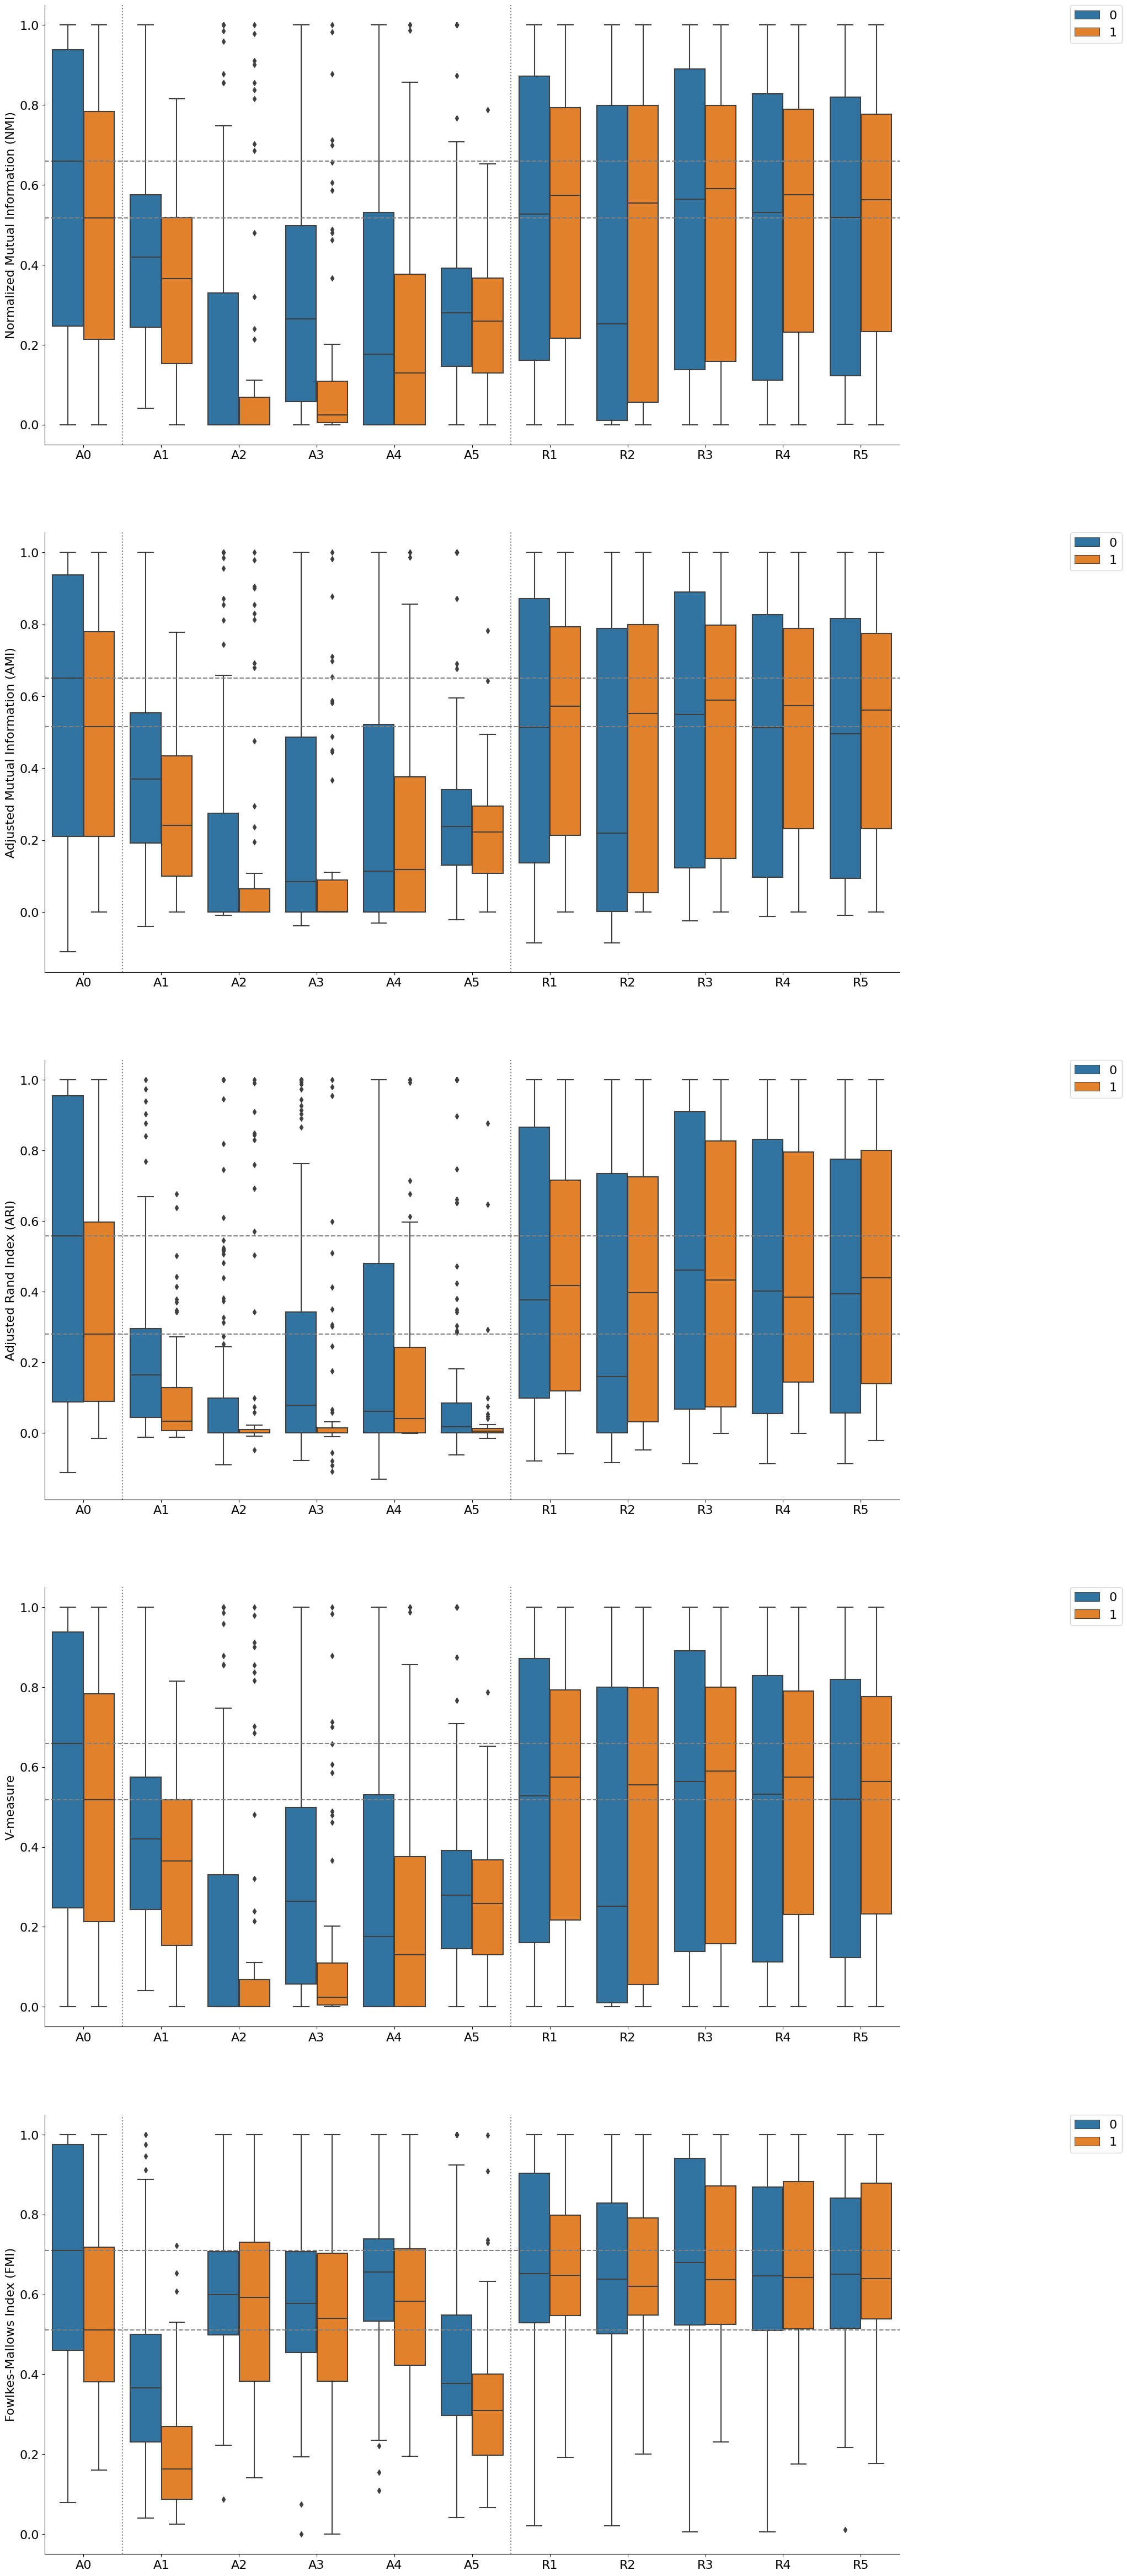

In [44]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_rows_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(
        data=all_methods_df,
        x="index",
        y=col,
        hue=hue,
        ax=ax[idx],
        dodge=True
    )
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 0)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 1)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()

In [45]:
pd.pivot_table(all_methods_df, values=list(title_dict.values()), index=["n_clusters_binary","index"],
                       aggfunc=np.median)

Adjusted Mutual Information (AMI)  \
n_clusters_binary index                                                            
0                 A0: Proposed method                                   0.457811   
                  A1: Affinity Propogation                              0.245225   
                  A2: DBSCAN                                            0.000000   
                  A3: Fast Search                                       0.060071   
                  A4: Mean Shift                                        0.019692   
                  A5: OPTICS                                            0.161866   
                  R1: Agglomerative                                     0.297297   
                  R2: BIRCH                                             0.155827   
                  R3: Gaussian Mixture Models                           0.346357   
                  R4: k-Means                                           0.318608   
                  R5: Mini-batch k-Means                                0.300795   
1                 A0: Proposed method                                   0.737498   
                  A1: Affinity Propogation                              0.478823   
                  A2: DBSCAN                                            0.000000   
                  A3: Fast Search                                       0.011082   
                  A4: Mean Shift                                        0.310154   
                  A5: OPTICS                                            0.302770   
                  R1: Agglomerative                                     0.727687   
                  R2: BIRCH                                             0.685798   
                  R3: Gaussian Mixture Models                           0.753953   
                  R4: k-Means                                           0.713462   
                  R5: Mini-batch k-Means                                0.700504   

                                               Adjusted Rand Index (ARI)  \
n_clusters_binary index                                                    
0                 A0: Proposed method                           0.329354   
                  A1: Affinity Propogation                      0.079388   
                  A2: DBSCAN                                    0.000000   
                  A3: Fast Search                               0.013555   
                  A4: Mean Shift                                0.018361   
                  A5: OPTICS                                    0.008160   
                  R1: Agglomerative                             0.241299   
                  R2: BIRCH                                     0.104476   
                  R3: Gaussian Mixture Models                   0.323845   
                  R4: k-Means                                   0.277187   
                  R5: Mini-batch k-Means                        0.276160   
1                 A0: Proposed method                           0.557939   
                  A1: Affinity Propogation                      0.178239   
                  A2: DBSCAN                                    0.000000   
                  A3: Fast Search                               0.000445   
                  A4: Mean Shift                                0.104724   
                  A5: OPTICS                                    0.017970   
                  R1: Agglomerative                             0.567661   
                  R2: BIRCH                                     0.512775   
                  R3: Gaussian Mixture Models                   0.603121   
                  R4: k-Means                                   0.595396   
                  R5: Mini-batch k-Means                        0.586901   

                                               Fowlkes-Mallows Index (FMI)  \
n_clusters_binary index                                                      
0                 A0: Proposed method            

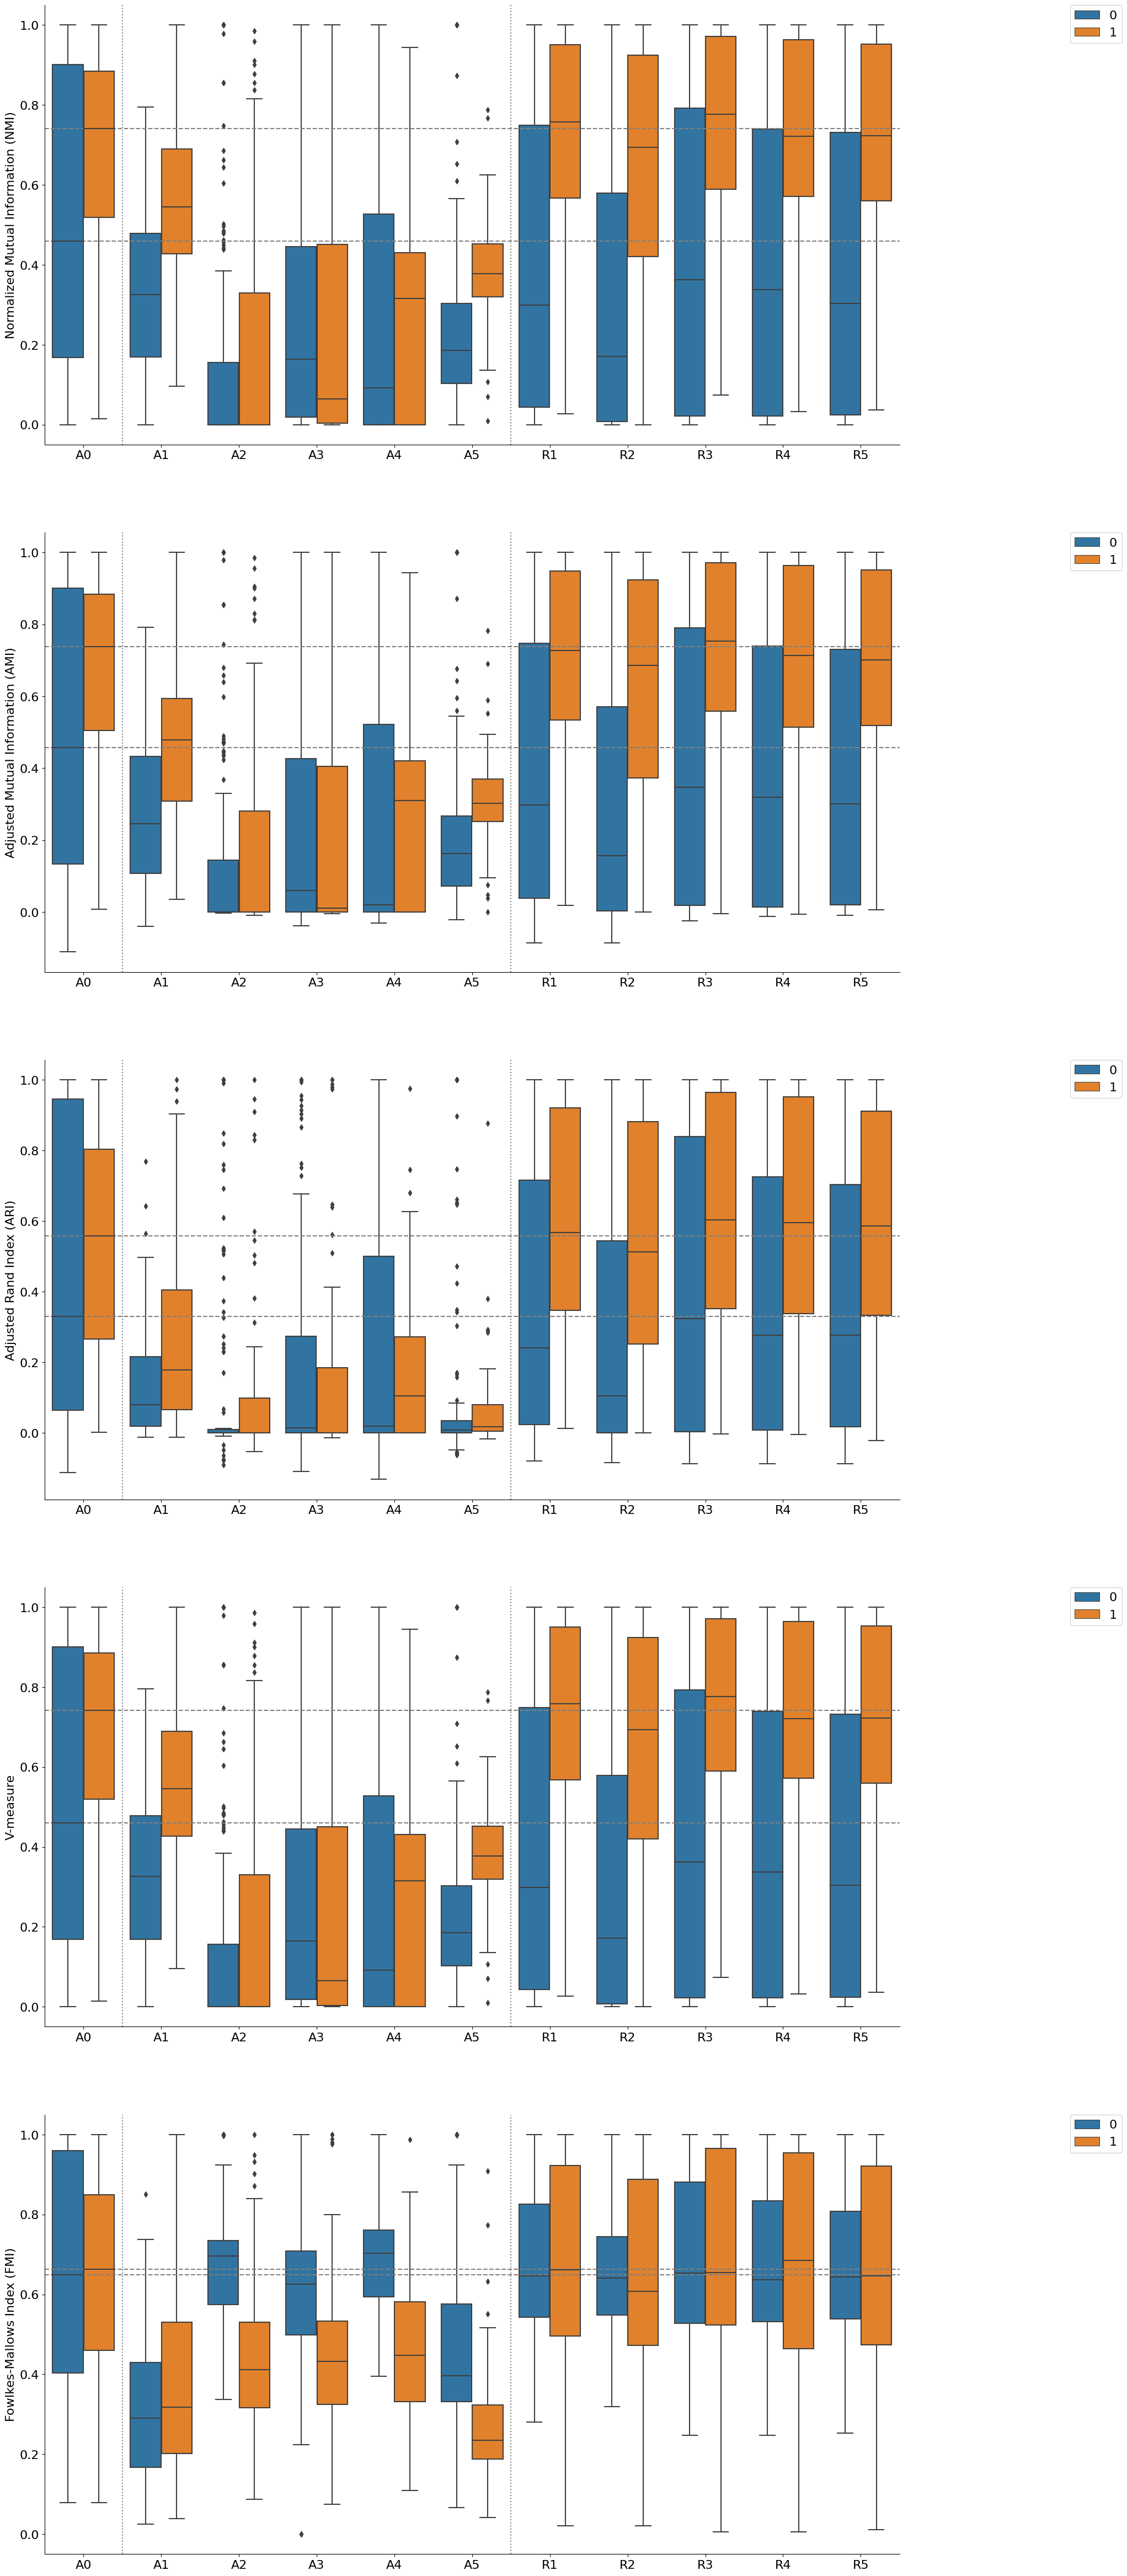

In [46]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(metrics_5_list), 1, figsize=(20, len(metrics_5_list) * 12))

hue = "n_clusters_binary"
for idx, col in enumerate(metrics_5_list):
    sns.boxplot(
        data=all_methods_df,
        x="index",
        y=col,
        hue=hue,
        ax=ax[idx],
        dodge=True
    )
    ax[idx].set_xticklabels([x[:2] for x in all_methods_df["index"].unique()])
    ax[idx].set(xlabel="", ylabel=col)
    ax[idx].legend(
        loc="upper right",
        labels=[],
        borderaxespad=0,
        bbox_to_anchor=(1.26, 1),
        handles=[],
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 0)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axhline(
        y=all_methods_df[(all_methods_df["index"] == "A0: Proposed method") & (all_methods_df[hue] == 1)].describe().loc["50%"][col],
        linestyle="dashed",
        color="gray",
    )
    ax[idx].axvline(x=0.5, color="gray", linestyle="dotted")
    ax[idx].axvline(x=5.5, color="gray", linestyle="dotted")
    sns.despine(ax=ax[idx])
plt.show()